## Single Point Robot Evaluation
This section evaluates the trained models, given the first record of a random observation group. From there, the models will need to predict how many sequences the trajectory has, followed by the entire trajectory of the shuttlecock, from start to end. Then after, based on the predicted trajectory, a robot has to decide how it needs to move in response to the shuttlecock moving to hit it back. 
### Dependencies for Single Point Evaluation

In [206]:
import numpy as np
import pandas as pd
import random
from joblib import load
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Methods for Preparing Data for Observation Sequence Predictor
Here some constants and methods are defined, used to prepare data for the decision tree that predicts how many observation sequences there are within a trajectory

In [207]:
# Independent features for regression models
INDEPENDENT_COLUMNS_REG = ['HUMAN PLAYER POSITION(X) metres', 
    'HUMAN PLAYER POSITION(Y) metres', 
    'HUMAN PLAYER POSITION(Z) metres',
    'INITIAL VELOCITY OF SHUTTLECOCK(m/s)', 
    'INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE)', 
    'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)',
    'OBSERVATION NUMBER']
# Independent features for LSTM models
INDEPENDENT_COLUMNS_LST = ['HUMAN PLAYER POSITION(X) metres',
    'HUMAN PLAYER POSITION(Y) metres',
    'HUMAN PLAYER POSITION(Z) metres',
    'OBSERVATION NUMBER', 
    'INITIAL VELOCITY OF SHUTTLECOCK(m/s)',
    'INITIAL SHUTTLECOCK FIRING ANGLE(RADIAN)', 
    'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(RADIAN)']
# Dependent features for all models
DEPENDENT_COLUMNS =['SHUTTLECOCK POSITION IN AIR(X) metres', 
    'SHUTTLECOCK POSITION IN AIR(Y) metres', 
    'SHUTTLECOCK POSITION IN AIR(Z) metres']

In [208]:
def load_single_observation_for_DT(filepath):
    """Loads and processes a single observation for shuttlecock number of observation sequences prediction by Decision Tree"""
    data = pd.read_csv(filepath)
   # Randomly select an observation group number
    unique_observation_grps = data['OBSERVATION GROUP NUMBER'].unique()
    selected_test_num = random.choice(unique_observation_grps.tolist())
    print(f"🔹 Selected Observation Group: {selected_test_num}")
    obs_grp_sequence = data[data['OBSERVATION GROUP NUMBER'] == selected_test_num]
    sequence = obs_grp_sequence.head(1)

    # Define features for number of sequence step prediction
    x_features = ['HUMAN PLAYER POSITION(X) metres',
        'HUMAN PLAYER POSITION(Y) metres',
        'HUMAN PLAYER POSITION(Z) metres',
        'INITIAL VELOCITY OF SHUTTLECOCK(m/s)',
        'INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE)',
        'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)']
    x_first_sequence = sequence[x_features]
    # Returns the entire sequence of observations, the single record, features for single record, and number of observations in the sequence
    return obs_grp_sequence, sequence, x_first_sequence, len(obs_grp_sequence)

### Predicting Number of Observation Sequences in a Trajectory
Using the decision tree that was trained previously, it is used to predict the number of observation sequences the observation group has given the single prepared data. 

In [209]:
normal_data_fp = "../../data/cleaned/normal_data.csv"
dt_fp = "../trained_models/decision_tree_model.pkl"
selected_sequences, first_sequence, x_first_sequence, num_of_seq = load_single_observation_for_DT(normal_data_fp)
x_first_sequence

🔹 Selected Observation Group: 545


,HUMAN PLAYER POSITION(X) metres,HUMAN PLAYER POSITION(Y) metres,HUMAN PLAYER POSITION(Z) metres,INITIAL VELOCITY OF SHUTTLECOCK(m/s),INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE),INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)
62198,4,2,2.6,10,40,29


In [210]:
observation_sequence_predictor_dt = load(open(dt_fp, 'rb'))
num_of_seq_pred = int(observation_sequence_predictor_dt.predict(x_first_sequence))
print(f"Predicted Number of Observation Sequences: {num_of_seq_pred}\nActual Number of Observation Sequences: {num_of_seq}")
if num_of_seq_pred == num_of_seq:
    print("🟢 Prediction is correct!")
else:
    print("🔴 Prediction is incorrect!")

Predicted Number of Observation Sequences: 128
Actual Number of Observation Sequences: 128
🟢 Prediction is correct!


C:\Users\mattz\AppData\Local\Temp\ipykernel_24920\1821626731.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_of_seq_pred = int(observation_sequence_predictor_dt.predict(x_first_sequence))


### Methods for Preparing Data for Trajectory Prediction
Defining variables and constants

In [211]:
COURT_LENGTH_X = 13.4  # Length of the court
COURT_LENGTH_Y = 5.18  # Width of the court
COURT_LENGTH_CENTRELINE = 4.68 # Length of the centreline
COURT_HEIGHT_SKYBOX = 15  # Maximum height of shuttlecock flight
COURT_HEIGHT_NET = 1.55  # Height of the net at the center

Methods used for preparing data for trajectory prediction for both LSTM and Regression models

In [212]:
def convert_angles_to_radians(data):
    """Convert angles to radians, renaming them too"""
    print(type(data))
    # Convert angles to radians
    data['INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE)'] = np.radians((data['INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE)']).astype(float))
    data['INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)'] = np.radians((data['INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)']).astype(float))
    # Renaming
    data = data.rename(columns={
    'INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE)': 'INITIAL SHUTTLECOCK FIRING ANGLE(RADIAN)',
    'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)': 'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(RADIAN)'})
    return data

def prepare_data_for_trajectory_prediction(sequence, num_of_seq_pred, to_normalise, scalar_X_fp=None):
    """Prepare data for trajectory prediction"""
    # Store the x features that will be used for trajectory prediction
    x_trajectory = pd.DataFrame(columns=sequence.columns)
    for obs_seq in range(1, num_of_seq_pred+1):
        temp_obs_row = sequence.copy()
        # Append observation number into each row
        temp_obs_row.loc[:,'OBSERVATION NUMBER'] = obs_seq
        # ✅ Ensure 'OBSERVATION NUMBER' remains an integer
        if not x_trajectory.empty:
            x_trajectory = pd.concat([x_trajectory, temp_obs_row], ignore_index=True)
        else:
            x_trajectory = temp_obs_row  # If empty, just set it
    x_trajectory['OBSERVATION NUMBER'] = x_trajectory['OBSERVATION NUMBER'].astype(int)
    # Prepare data for LSTM trajectory prediction
    if to_normalise and scalar_X_fp:
        # Convert angles to radian
        x_trajectory = convert_angles_to_radians(x_trajectory)
        # Normalise and reshape features
        scalar_X = load(scalar_X_fp)
        x_trajectory_scaled = scalar_X.transform(x_trajectory)
        x_trajectory_scaled_shaped = x_trajectory_scaled.reshape(x_trajectory_scaled.shape[0], 1, x_trajectory_scaled.shape[1])
        return x_trajectory_scaled_shaped
    # If for regression models, no further preparation required, return
    else:
        return x_trajectory
    
def unnormalise_results(scaler_Y_path, y_pred_scaled):
    """Unnormalise LSTM model predictions to real world values."""
    if scaler_Y_path is None:
        raise ValueError("❌ Error: scaler_Y must be provided to unnormalize predictions.")
    scaler_Y = load(scaler_Y_path)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled)
    return y_pred

In [213]:
def plot_shuttlecock_trajectory(y_actual, y_pred, model_name):
    """Plots the shuttlecock trajectory in 3D, overlaying it onto a badminton court."""
    # Create a figure with two subplots: left for predicted, right for actual
    fig = plt.figure(figsize=(16, 8))

    # Left subplot - Predicted Trajectory
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Predicted Shuttlecock Trajectory")
    ax1.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], c='red', label="Predicted Trajectory", alpha=0.6)
    
    # Right subplot - Actual Trajectory
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Actual Shuttlecock Trajectory")
    ax2.scatter(y_actual[:, 0], y_actual[:, 1], y_actual[:, 2], c='blue', label="Actual Trajectory", alpha=0.6)

    # Apply the same settings to both plots for consistency
    for ax in [ax1, ax2]:
        # Plot court boundaries
        ax.plot([0, COURT_LENGTH_X], [0, 0], [0, 0], color='black', linewidth=2)  # Bottom boundary
        ax.plot([0, COURT_LENGTH_X], [COURT_LENGTH_Y, COURT_LENGTH_Y], [0, 0], color='black', linewidth=2)  # Top boundary
        ax.plot([0, 0], [0, COURT_LENGTH_Y], [0, 0], color='black', linewidth=2)  # Left boundary
        ax.plot([COURT_LENGTH_X, COURT_LENGTH_X], [0, COURT_LENGTH_Y], [0, 0], color='black', linewidth=2)  # Right boundary

        # Plot center line
        ax.plot([0, COURT_LENGTH_CENTRELINE], [COURT_LENGTH_Y / 2, COURT_LENGTH_Y / 2], [0, 0], color='black', linewidth=1)
        ax.plot([COURT_LENGTH_X - COURT_LENGTH_CENTRELINE, COURT_LENGTH_X], [COURT_LENGTH_Y / 2, COURT_LENGTH_Y / 2], [0, 0], color='black', linewidth=1)

        # Plot short service lines
        ax.plot([COURT_LENGTH_CENTRELINE + 0.04, COURT_LENGTH_CENTRELINE + 0.04], [0, COURT_LENGTH_Y], [0, 0], color='black', linewidth=1)         
        ax.plot([COURT_LENGTH_X - COURT_LENGTH_CENTRELINE - 0.04, COURT_LENGTH_X - COURT_LENGTH_CENTRELINE - 0.04], [0, COURT_LENGTH_Y], [0, 0], color='black', linewidth=1)

        # Plot net
        ax.plot([COURT_LENGTH_X / 2, COURT_LENGTH_X / 2], [0, COURT_LENGTH_Y], [COURT_HEIGHT_NET, COURT_HEIGHT_NET], 
                color='red', linewidth=2, label="Net")
        ax.view_init(elev=20, azim=45)  # Set the view angle
        # Set plot limits and labels
        ax.set_xlim([0, COURT_LENGTH_X])
        ax.set_ylim([0, COURT_LENGTH_Y])
        ax.set_zlim([0, COURT_HEIGHT_SKYBOX])
        ax.set_xlabel("Court Length (m)")
        ax.set_ylabel("Court Width (m)")
        ax.set_zlabel("Shuttlecock Height (m)")
        ax.legend()
    full_title = f'Predicted vs Actual Trajectories for {model_name}'
    plt.suptitle(full_title)
    # Show the plot
    plt.tight_layout()
    plt.show()

### Predicting Single Trajectories with LSTM RNN (Normal)

In [214]:
lstm_normal_fp = "../trained_models/lstm_rnn_model_normal.keras"
scaler_X_path_normal = "../trained_models/lstm_rnn_model_normal_scaler_X.pkl"
scaler_Y_path_normal = "../trained_models/lstm_rnn_model_normal_scaler_Y.pkl"

In [215]:
generated_x_trajectory_lstm = prepare_data_for_trajectory_prediction(x_first_sequence, num_of_seq_pred, True, scaler_X_path_normal)
lstm_normal_model = tf.keras.models.load_model(lstm_normal_fp)

# Generate and unnormalise predictions
y_trajectory_pred_scaled = lstm_normal_model.predict(generated_x_trajectory_lstm)
y_trajectory_pred_lstm = unnormalise_results(scaler_Y_path_normal, y_trajectory_pred_scaled)

<class 'pandas.core.frame.DataFrame'>
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


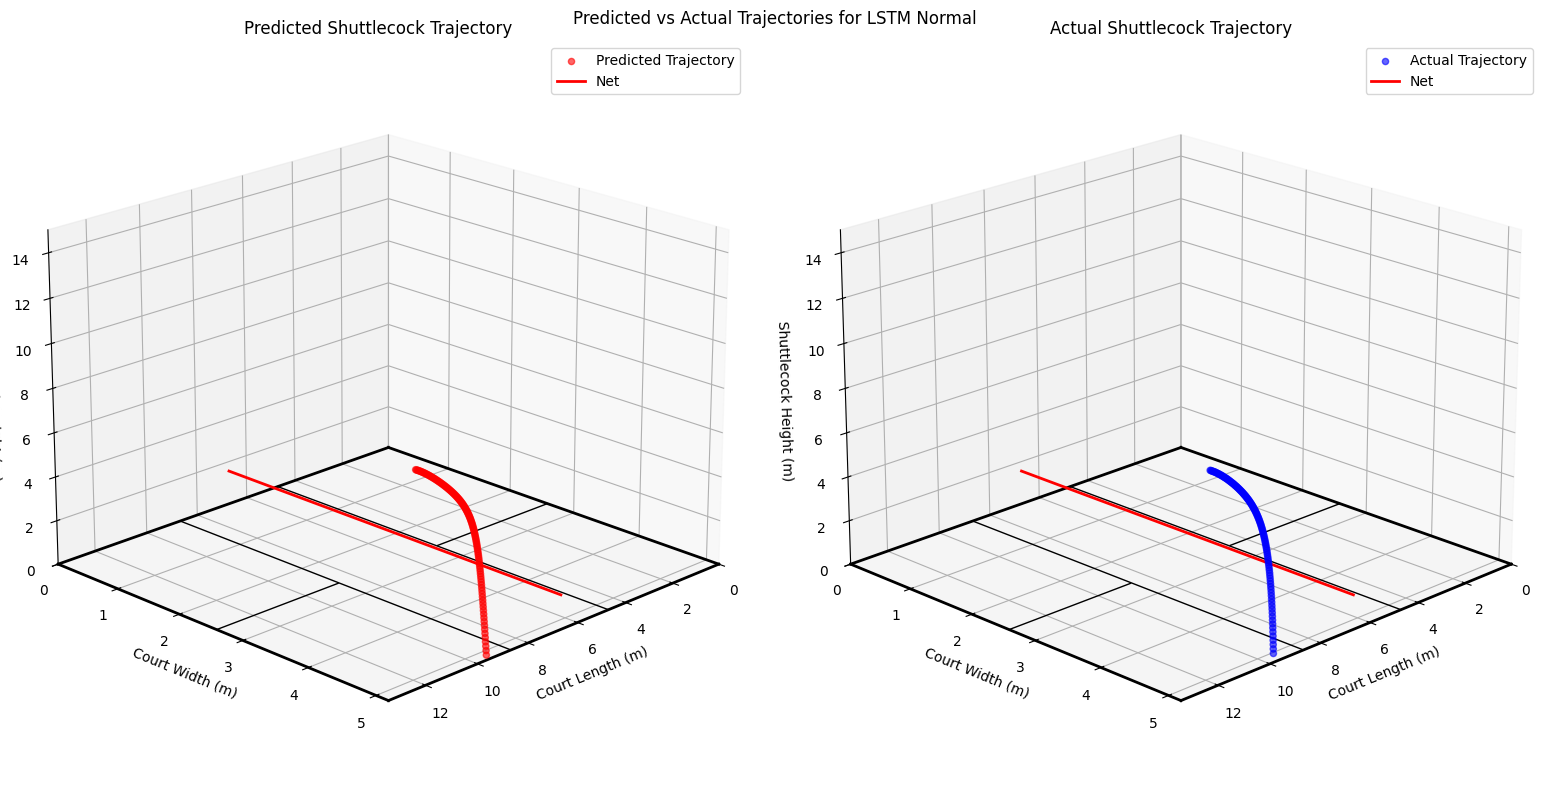

In [216]:
y_trajectory = selected_sequences[DEPENDENT_COLUMNS]
y_trajectory = np.array(y_trajectory)
plot_shuttlecock_trajectory(y_trajectory, y_trajectory_pred_lstm, "LSTM Normal")

### Predicting Single Trajectories with Random Forest Regressor (Normal)

In [217]:
rf_normal_fp = "../trained_models/random_forest_model_normal.pkl"

In [218]:
generated_x_trajectory_rf = prepare_data_for_trajectory_prediction(x_first_sequence, num_of_seq_pred, False)
rf_normal_model = load(open(rf_normal_fp, 'rb'))

# Generate predictions
y_trajectory_pred_rf = rf_normal_model.predict(generated_x_trajectory_rf)

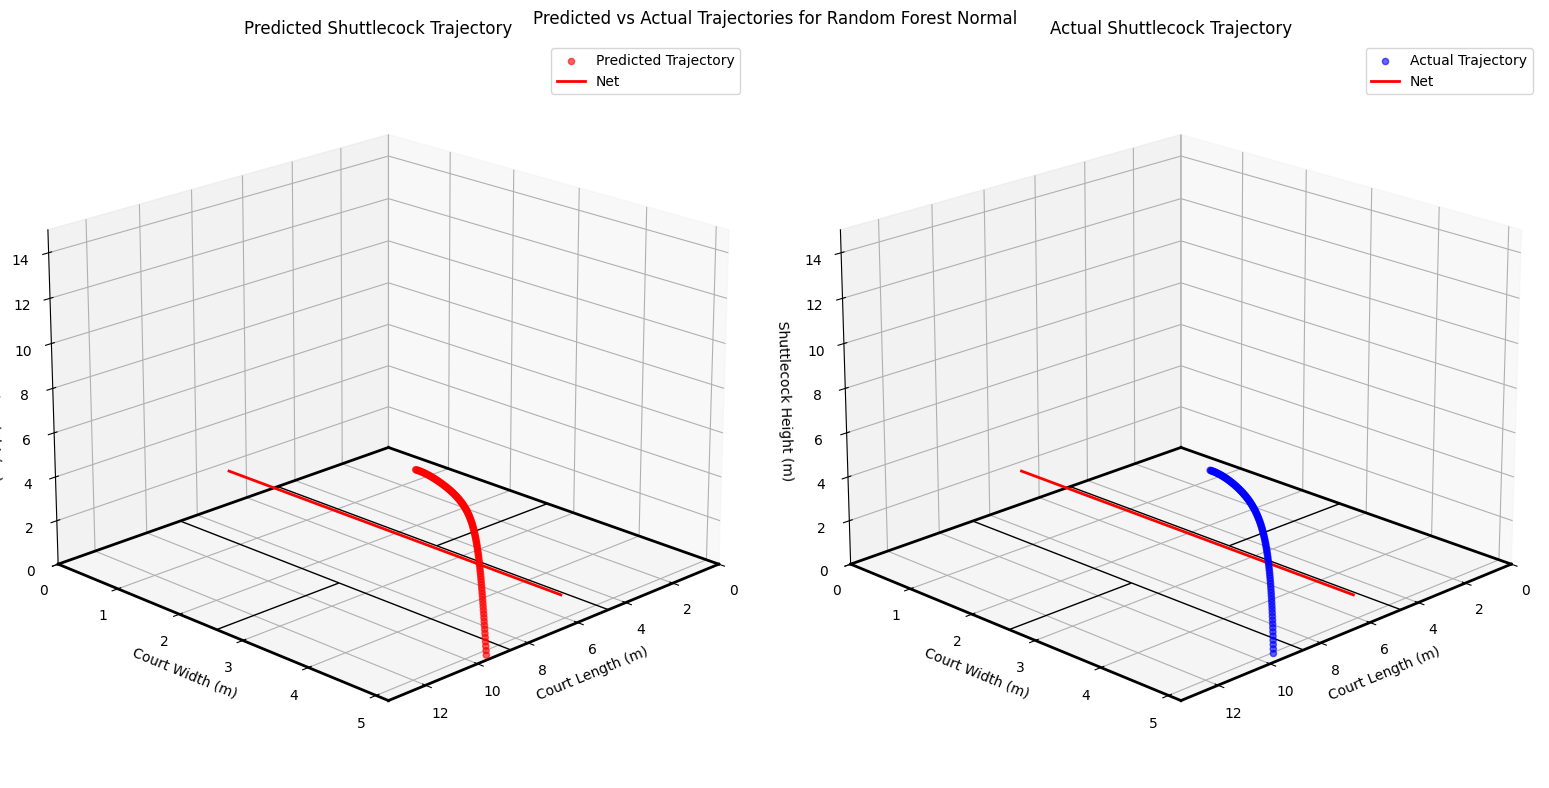

In [219]:
y_trajectory = selected_sequences[DEPENDENT_COLUMNS]
y_trajectory = np.array(y_trajectory)
plot_shuttlecock_trajectory(y_trajectory, y_trajectory_pred_lstm, "Random Forest Normal")

### Predicting Single Trajectories with Extra Trees Regressor (Normal)

In [220]:
et_normal_fp = "../trained_models/extra_trees_model_normal.pkl"

In [221]:
generated_x_trajectory_et = prepare_data_for_trajectory_prediction(x_first_sequence, num_of_seq_pred, False)
et_normal_model = load(open(et_normal_fp, 'rb'))

# Generate predictions
y_trajectory_pred_et = et_normal_model.predict(generated_x_trajectory_et)

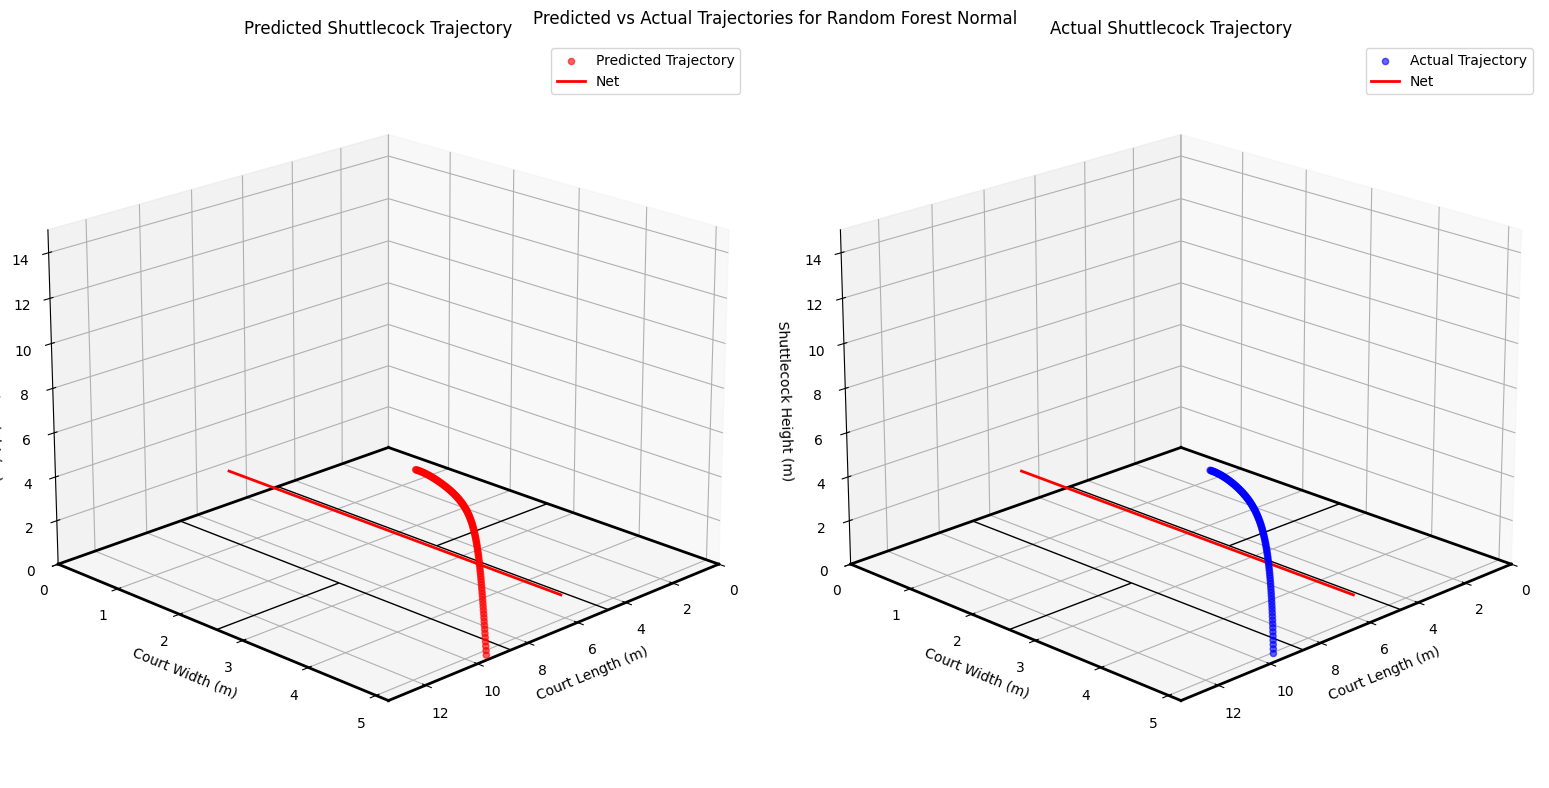

In [222]:
y_trajectory = selected_sequences[DEPENDENT_COLUMNS]
y_trajectory = np.array(y_trajectory)
plot_shuttlecock_trajectory(y_trajectory, y_trajectory_pred_lstm, "Random Forest Normal")

### Methods for Robot's Response to Shuttlecock 

Defined constants and variables

In [223]:
OBSERVATION_INTERVAL = 0.01

ROBOT_LENGTH = 0.68 # 68cm to metres
ROBOT_WIDTH = 0.23 # 23cm to metres
ROBOT_SPEED = 7.5 # 5 metres per second (Specificatio says 2m/s but it never hits in that case, always too late)
ROBOT_HITTING_HEIGHT = 1.2 * 0.875 # hit shuttlecock in top quarter of racket, thus 1.2m * 0.875

# Ranges for robot initial starting positions
ROBOT_X_RANGE = [0, 4.72]
ROBOT_Y_RANGE = [0, 5.18]

Methods for helping robots make decisions and actions

In [224]:
def is_within_court(shuttlecock_x,shuttlecock_y):
    """Check if a point's X and Y coordinates are within the court's boundaries"""
    return  (0 <= shuttlecock_x <= COURT_LENGTH_X and 0 <= shuttlecock_y <= COURT_LENGTH_Y)  # Z disregarded, height doesn't matter in badminton court boundary
        
def find_best_hitting_point(y_trajectory_pred):
    """Returns observation sequence with height closest to robot hitting height"""
    # Creates an list of absolute differences between the predicted Z values and the hitting height
    z_differences = np.abs(y_trajectory_pred[:, 2] - ROBOT_HITTING_HEIGHT)
    # Finds the index of the observation sequence with the closest Z value to the hitting height
    closest_index = np.argmin(z_differences)
    return closest_index, y_trajectory_pred[closest_index]

def compute_distance(x_robot, y_robot, x_shuttlecock, y_shuttle):
    """Calculates Euclidean between the robot and the shuttlecock X and Y points"""
    x_displacement = x_shuttlecock - x_robot
    y_displacement = y_shuttle - y_robot
    # Calculate the resultant displacement
    return np.sqrt(x_displacement**2 + y_displacement**2)

def calculate_max_time_to_move(sequence_num):
    """Calculates the maximum time for the robot to move to the shuttlecock"""
    return (sequence_num + 1) * OBSERVATION_INTERVAL # 0.01s, 10ms per observation

def can_robot_reach_shuttlecock(robot_x, robot_y, y_trajectory_pred):
    closest_index, target_sequence = find_best_hitting_point(y_trajectory_pred)
    distance_to_target = compute_distance(robot_x, robot_y, target_sequence[0], target_sequence[1])
    available_time = calculate_max_time_to_move(closest_index)
    movement_time = distance_to_target / ROBOT_SPEED
    # Robot can reach on time
    if movement_time <= available_time:
        wait_time = available_time - movement_time
        return True, movement_time, available_time, wait_time, target_sequence
    # Robot can't reach on time
    else:  
        return False, movement_time, available_time, 0, target_sequence
    
def generate_random_robot_position():
    """Generates a random robot position within the court"""
    robot_x = random.uniform(ROBOT_X_RANGE[0], ROBOT_X_RANGE[1])
    robot_y = random.uniform(ROBOT_Y_RANGE[0], ROBOT_Y_RANGE[1])
    return robot_x, robot_y


In [225]:
robot_x, robot_y = generate_random_robot_position()
print(f"Robot starts are position {robot_x:.2f} X and {robot_y:.2f} Y coordinates.")
last_shuttlecock_sequence = y_trajectory_pred_lstm[-1]
robot_should_move = False
within_court = is_within_court(last_shuttlecock_sequence[0], last_shuttlecock_sequence[1])

if within_court:
    robot_reach_shuttlecock, movement_time, available_time, wait_time, target_sequence = can_robot_reach_shuttlecock(robot_x, robot_y, y_trajectory_pred_lstm)
    if robot_reach_shuttlecock:
        print(f"✅ Robot can reach the shuttlecock in {movement_time:.2f} seconds within the {available_time:.2f} seconds available time\nand needs to wait for {wait_time:.2f} seconds before hitting it at {target_sequence[0]:.2f} X and {target_sequence[1]:.2f} Y coordinates.")
    else:
        print(f"❌ Robot cannot reach the shuttlecock in time.\nMovement time {movement_time:.2f} seconds exceed available time {available_time:.2f}\nto reach the shuttlecock at {target_sequence[0]:.2f} X and {target_sequence[1]:.2f} Y coordinates.")
else:
    print(f"❌ Final predicted shuttlecock trajectory {last_shuttlecock_sequence[0]:.2f} x, {last_shuttlecock_sequence[1]:.2f} Y coordinates is not within the court boundaries (Out)\nNo action taken by robot.")


Robot starts are position 3.50 X and 4.82 Y coordinates.
✅ Robot can reach the shuttlecock in 0.79 seconds within the 1.22 seconds available time
and needs to wait for 0.43 seconds before hitting it at 9.42 X and 5.07 Y coordinates.


In [226]:
# Code to print out the plot
def plot_robot_movement(y_trajectory_pred, robot_x, robot_y, target_sequence, last_shuttlecock_sequence, within_court, robot_reach_shuttlecock):
    """Plots the shuttlecock trajectory, robot's initial position, movement path, and final hitting point"""

    # Create 3D figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    # 1️⃣ Plot the shuttlecock trajectory
    ax.plot(y_trajectory_pred[:, 0], y_trajectory_pred[:, 1], y_trajectory_pred[:, 2], color="blue", marker="o", markersize=2, label="Shuttlecock Trajectory")

    # 2️⃣ Plot the robot's initial position
    ax.scatter(robot_x, robot_y, 0, color="red", marker="s", s=80, label="Robot Start")

    # 3️⃣ Plot the target hitting position (if reachable)
    if within_court:
        if robot_reach_shuttlecock:
            ax.scatter(target_sequence[0], target_sequence[1], target_sequence[2], color="green", marker="X", s=100, label="Hitting Point")
            ax.plot([robot_x, target_sequence[0]], [robot_y, target_sequence[1]], [0, target_sequence[2]], linestyle="dashed", color="black", label="Robot Movement")
        # 5️⃣ If robot **cannot** reach, shade the **attempted path** in gray
        else:
            ax.scatter(target_sequence[0], target_sequence[1], target_sequence[2], color="green", marker="X", s=100, label="Hitting Point")
            ax.plot([robot_x, target_sequence[0]], [robot_y, target_sequence[1]], [0, target_sequence[2]], linestyle="dashed", color="gray", label="Attempted Movement (Failed)")
            ax.text(robot_x, robot_y, 0.2, "Attempted Movement (Lack of Time)", fontsize=10, color="red")
    else:
        ax.text(robot_x, robot_y, 0.2, "No Movement (Out of Bounds)", fontsize=10, color="red")
    # 4️⃣ Mark the final shuttlecock landing position (for reference)
    ax.scatter(last_shuttlecock_sequence[0], last_shuttlecock_sequence[1], last_shuttlecock_sequence[2], color="purple", marker="D", s=80, label="Final Landing Point")

    # 5️⃣ Draw court boundaries (floor level, Z=0)
    court_x = [0, COURT_LENGTH_X, COURT_LENGTH_X, 0, 0]
    court_y = [0, 0, COURT_LENGTH_Y, COURT_LENGTH_Y, 0]
    ax.plot(court_x, court_y, [0]*5, color="black", linestyle="solid", label="Court Boundary")

    ax.set_box_aspect([2, 1, 1])  # Makes X-axis wider than Y and Z
    ax.view_init(elev=20, azim=45)  # Set the view angle

    # Set axis labels and title
    ax.set_xlabel("X (Court Length)")
    ax.set_ylabel("Y (Court Width)")
    ax.set_zlabel("Z (Height)")
    ax.set_title("Robot Movement & Shuttlecock Trajectory")
    
    plt.legend()
    plt.show()

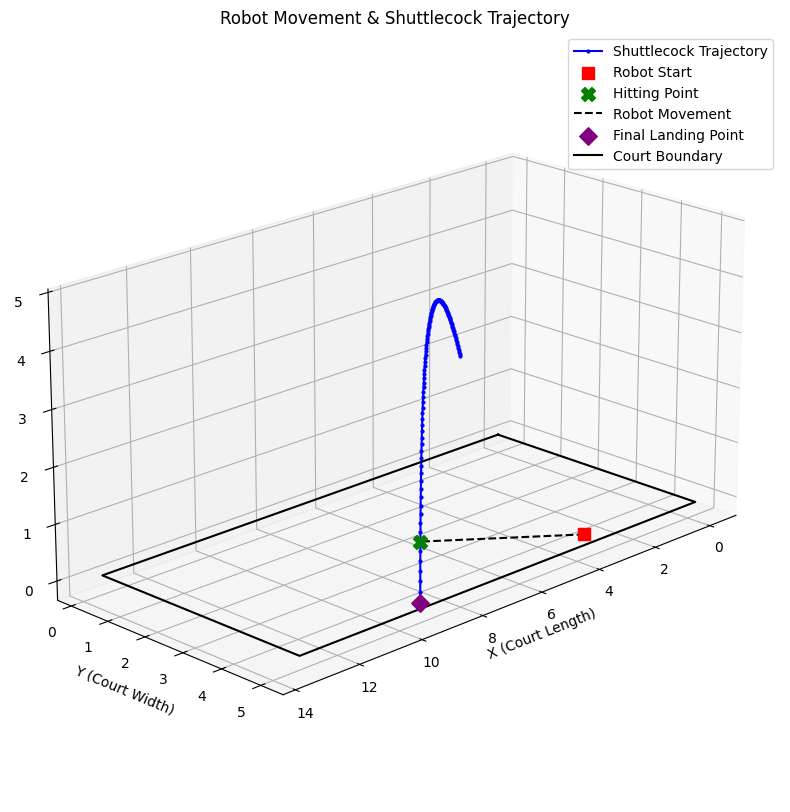

In [227]:
plot_robot_movement(y_trajectory_pred_lstm, robot_x, robot_y, target_sequence, last_shuttlecock_sequence, within_court, robot_reach_shuttlecock)